In [1]:
import pandas as pd

def split_runs(df, time_col="time"):
    """
    Splits a DataFrame into separate runs whenever the time column resets to 1.
    Returns a list of DataFrames (one per run).
    """
    runs = []
    run_start_indices = df.index[df[time_col] == 1].tolist()
    run_start_indices.append(len(df))  # sentinel for last run

    for i in range(len(run_start_indices) - 1):
        start, end = run_start_indices[i], run_start_indices[i+1]
        runs.append(df.iloc[start:end].reset_index(drop=True))
    return runs


# Hardcoded files
files = [
    "MapField/FindSampleRate.csv",
    "MapField/FindSampleRate2.csv",
    "MapField/FindSampleRate3.csv",
]

for file in files:
    df = pd.read_csv(file)  # adjust sep if needed

    # Split into runs
    runs = split_runs(df)

    # Save each run as its own .dat
    for i, run in enumerate(runs, start=1):
        outname = file.replace(".csv", f"_run{i}.dat")
        run.to_csv(outname, sep="\t", index=False)
        print(f"Saved {outname}")


Saved MapField/FindSampleRate_run1.dat
Saved MapField/FindSampleRate_run2.dat
Saved MapField/FindSampleRate_run3.dat
Saved MapField/FindSampleRate_run4.dat
Saved MapField/FindSampleRate2_run1.dat
Saved MapField/FindSampleRate2_run2.dat
Saved MapField/FindSampleRate2_run3.dat
Saved MapField/FindSampleRate2_run4.dat
Saved MapField/FindSampleRate2_run5.dat
Saved MapField/FindSampleRate3_run1.dat
Saved MapField/FindSampleRate3_run2.dat


## Experiment File Notes – Run Splitting

Each CSV in **MapField/** contains multiple runs of the experiment.  
Runs are separated by the **time column resetting back to 1**.  
When processing, split into runs and save each as its own `.dat` file.

### File → Runs
- **FindSampleRate.csv**
  - Run1 → 50 points, 1 point per second  
  - Run2 → static point (1st velocity calibration/calculation + error)  
  - Run3 → static point at 6 mm  
  - Run4 → static point at 7 mm  

- **FindSampleRate2.csv**
  - Run1 → 100 points, 1 per 0.5 s  
  - Run2 → 200 points, 1 per 0.25 s  
  - Run3 → 400 points, 1 per 0.125 s  
  - Run4 → 500 points, 1 per 0.1 s  
  - Run5 → 333 points, 1 per 0.15 s (broken)  

- **FindSampleRate3.csv**
  - Run1 → 334 points, 1 per 0.15 s  
  - Run2 → 400 points, 1 per 0.25 s  

### Saving convention
- Output each run as:  
  `FindSampleRate_runX.dat`  
  `FindSampleRate2_runX.dat`  
  `FindSampleRate3_runX.dat`  

### Reminder
- Splitting trigger = **time column resets to 1**  
- Save each run as tab-delimited `.dat`  
- If separator is unclear, try `sep="\t"` first, fallback to `sep=","`  


## Plotting Flux vs Time for Each Valid Run

Goal:
- For each `.dat` run that has a valid "1 per ..." sampling rate and is not broken,
  plot **Flux vs Time**.
- Ignore `FindSampleRate2_run5.dat` (broken).
- Each run is saved as a tab-delimited `.dat`.

Steps:
1. Load each `.dat` into a DataFrame (`pd.read_csv(..., sep="\t")`).
2. Identify the `time` column (sometimes named `Time`, `time(s)`, etc.).
3. Plot `flux` vs. `time` using matplotlib.


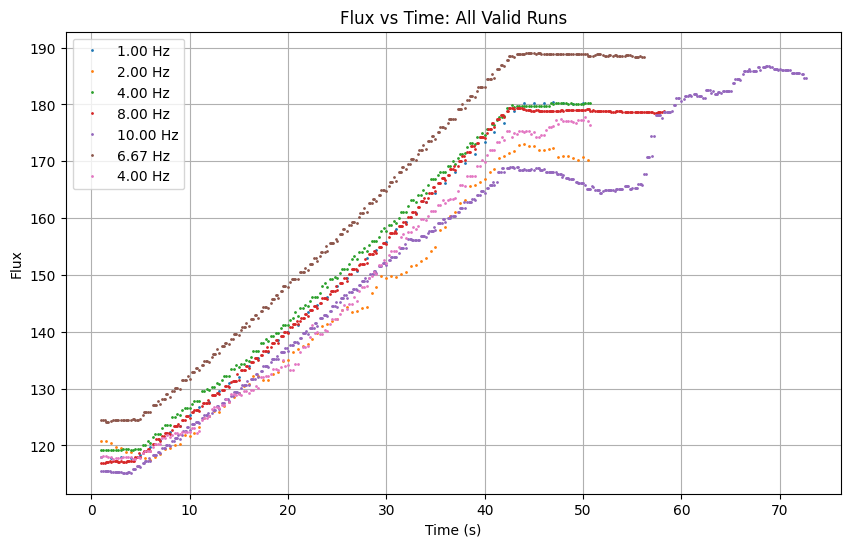

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Dictionary of valid files and their sampling interval
dat_files = {
    "FindSampleRate_run1.dat": "1 pt/1 s",
    "FindSampleRate2_run1.dat": "1 pt/0.5 s",
    "FindSampleRate2_run2.dat": "1 pt/0.25 s",
    "FindSampleRate2_run3.dat": "1 pt/0.125 s",
    "FindSampleRate2_run4.dat": "1 pt/0.1 s",
    "FindSampleRate3_run1.dat": "1 pt/0.15 s",
    "FindSampleRate3_run2.dat": "1 pt/0.25 s"
}

plt.figure(figsize=(10,6))

for i, (file, interval) in enumerate(dat_files.items()):
    df = pd.read_csv(f"MapField/{file}", sep="\t")
    
    time_col = [c for c in df.columns if "time" in c.lower()][0]
    flux_col = [c for c in df.columns if "flux" in c.lower()][0]
    
    sec = float(interval.split('/')[-1].replace(' s',''))
    freq = 1/sec
    
    plt.plot(df[time_col], df[flux_col], marker=".", 
             linestyle='None', markersize=2, label=f"{freq:.2f} Hz")

plt.title("Flux vs Time: All Valid Runs")
plt.xlabel("Time (s)")
plt.ylabel("Flux")
plt.legend()
plt.grid(True)
plt.show()


In [28]:
summary = []

for file, interval in dat_files.items():
    df = pd.read_csv(f"MapField/{file}", sep="\t")
    
    # Detect time column
    time_col = [c for c in df.columns if "time" in c.lower()][0]
    
    # Filter to 10 ≤ time ≤ 40 s
    df_window = df[(df[time_col] >= 0) & (df[time_col] <= 50)]
    
    # Compute claimed sampling rate from the interval string
    seconds_per_point = float(interval.split('/')[-1].strip().split()[0])
    claimed_fs = 1 / seconds_per_point
    
    # Compute Δt and effective sampling rate in the window
    dt = df_window[time_col].diff().dropna()
    fs = 1 / dt.mean()
    
    summary.append({
        #"File": file,
        "Claimed Sampling Rate (Hz)": round(claimed_fs, 2),
        "Effective Sampling Rate (Hz)": round(fs, 2)
    })

summary_df = pd.DataFrame(summary)
summary_df

,Claimed Sampling Rate (Hz),Effective Sampling Rate (Hz)
0,1.00,1.00
1,2.00,2.00
2,4.00,4.00
3,8.00,6.98
4,10.00,6.98
5,6.67,6.04
6,4.00,4.00


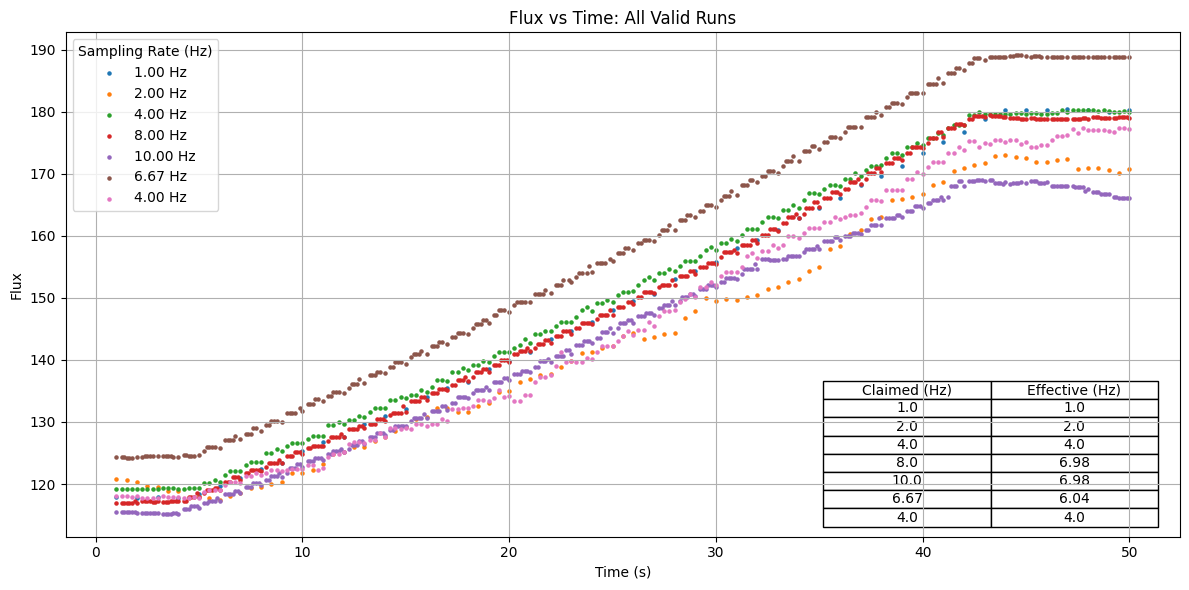

In [30]:
plt.figure(figsize=(12,6))

for i, (file, interval) in enumerate(dat_files.items()):
    df = pd.read_csv(f"MapField/{file}", sep="\t")
    
    # Detect columns
    time_col = [c for c in df.columns if "time" in c.lower()][0]
    flux_col = [c for c in df.columns if "flux" in c.lower()][0]

    # Filter to time <= 50 s
    df = df[df[time_col] <= 50]
    
    # Compute nominal Hz from interval string
    denom = float(interval.split("pt/")[1].split()[0])
    hz = 1 / denom
    
    plt.scatter(df[time_col], df[flux_col], s=20, marker=".", label=f"{hz:.2f} Hz")

plt.title("Flux vs Time: All Valid Runs")
plt.xlabel("Time (s)")
plt.ylabel("Flux")
plt.grid(True)
plt.legend(title="Sampling Rate (Hz)")

# Add table using summary_df
plt.table(cellText=summary_df[['Claimed Sampling Rate (Hz)','Effective Sampling Rate (Hz)']].values,
          colLabels=['Claimed (Hz)','Effective (Hz)'],
          loc='lower right',
          colWidths=[0.15]*2,
          cellLoc='center')

plt.tight_layout()
# Save figure
plt.savefig("flux_vs_time_with_summary.png", dpi=300)
plt.show()